### Setup

In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

import matplotlib.pyplot as plt
import pickle 
import torch as th
import torch.nn.functional as F
import torch
import networkx as nx
import pandas as pd
import numpy as np
import dgl 

import torch_geometric
from torch_geometric.explain import Explainer, CaptumExplainer, DummyExplainer, GNNExplainer
from torch_geometric.explain.metric import *
from torch_geometric.nn.models.basic_gnn import GraphSAGE
from torch_geometric.utils import from_dgl
from tqdm import tqdm
from torch_geometric.explain import ModelConfig
import scienceplots
from explanations import *
        

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [2]:
test = pd.read_csv('../../interm/BoT_test.csv')
attrs = [c for c in test.columns if c not in ("src", "dst", "Attack", "x", "IPV4_SRC_ADDR_metadata", "L4_SRC_PORT_metadata", 
                                              "IPV4_DST_ADDR_metadata", "L4_DST_PORT_metadata") 
        #  and not c.endswith('_metadata')
         ]
test['x'] = test[attrs].values.tolist()
test[:1]


,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,Attack,src,dst,x,FLOW_START_MILLISECONDS_metadata,FLOW_END_MILLISECONDS_metadata,IPV4_SRC_ADDR_metadata,L4_SRC_PORT_metadata,IPV4_DST_ADDR_metadata,L4_DST_PORT_metadata
0,-0.236904,-0.236926,-0.503789,106,-0.17034,-0.2804,-0.071477,-0.149842,1.257089,1.728738,...,0,192.168.100.3:-1.0586554,192.168.100.149:2.6106632,"[-0.23690394, -0.23692596, -0.5037887, 106.0, ...",1.526968e+12,1.526968e+12,192.168.100.3,80.0,192.168.100.149,34502.0


<IPython.core.display.Javascript object>

In [3]:
def to_graph(data, linegraph=True):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph()) 
    
    G = G.to_directed()
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    if linegraph:
        return g.line_graph(shared=True)
    else:
        return g

model = GraphSAGE(49,
                  hidden_channels=256,
                  out_channels=5,
                  num_layers=3).to(device)

model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))
model.eval()

/tmp/ipykernel_2506/3588832698.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))


GraphSAGE(49, 5, num_layers=3)

<IPython.core.display.Javascript object>

In [4]:
G = to_graph(test)
G.ndata['x'][0][-1], G.ndata['x'][0][-2] # unscaled start and stop times


(tensor(1.5270e+12), tensor(1.5270e+12))

<IPython.core.display.Javascript object>

### Motifs

In [5]:
import torch, networkx as nx, dgl
from torch_geometric.transforms import LineGraph
from torch_geometric.utils import from_dgl

# 1) Build NX, then RELABEL to 0..N-1 to avoid gaps/off-by-one
nx_g = nx.from_pandas_edgelist(
    test, source='src', target='dst',
    edge_attr=['x', 'Attack'],
    create_using=nx.DiGraph()
)
# nx_g = nx.convert_node_labels_to_integers(nx_g, ordering='sorted') # ! ?

# 2) DGL graph + edge motifs (on *edges*)
dgl_g = dgl.from_networkx(nx_g, edge_attrs=['x', 'Attack'])
src, dst = dgl_g.edges()
out_deg = dgl_g.out_degrees()
in_deg  = dgl_g.in_degrees()

scanning_star_nodes = (out_deg > 10).nonzero(as_tuple=True)[0]
fan_nodes           = (in_deg  > 10).nonzero(as_tuple=True)[0]

is_star = torch.isin(src, scanning_star_nodes).to(torch.uint8)
is_fan  = torch.isin(dst, fan_nodes).to(torch.uint8)
new = torch.vstack([is_star, is_fan])

print(dgl_g.edata['x'].shape)
dgl_g.edata['x'] = torch.hstack([dgl_g.edata['x'], new.T])
print(dgl_g.edata['x'].shape)

dgl_lg = dgl_g.line_graph(shared=True)
pyg_lg = from_dgl(dgl_g)
pyg_lg.num_nodes = int(pyg_lg.edge_index.max()) + 1

torch.Size([12631, 51])
torch.Size([12631, 53])


<IPython.core.display.Javascript object>

In [6]:
# star_motifs = []
# for hub in scanning_star_nodes.tolist():
#     # find edges with this hub as source
#     lg_nodes = (src == hub).nonzero(as_tuple=True)[0].tolist()
#     if lg_nodes:  # only if non-empty
#         star_motifs.append(lg_nodes)

# fan_motifs = []
# for sink in fan_nodes.tolist():
#     # find edges with this sink as target
#     lg_nodes = (dst == sink).nonzero(as_tuple=True)[0].tolist()
#     if lg_nodes:
#         fan_motifs.append(lg_nodes)

<IPython.core.display.Javascript object>

In [7]:
pyg_lg.x[:, 51].sum(), pyg_lg.x[:, 52].sum()

(tensor(1975.), tensor(4727.))

<IPython.core.display.Javascript object>

### NIDS-GNNExplainer
- motif coherence reward $= - \lambda_{mc} \cdot \sum_{g \in \text{motifs}} || m_g ||_2$
- temporal smoothness penalty =  $\lambda_{ts} \cdot \text{exp}(\frac{-(t_i - t_j)^2}{2\sigma^2}) ||m_i - m_j||^2$
- threshhold sparsity penalty = $1/N \sum \mathcal{I}(n > k) $

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric.explain import GNNExplainer

class CustomGNNExplainer(GNNExplainer):
    
    params = {
        'ts_coef': 0,
        'motif_coef': 0,
        'sparsity_coef': 0,
        'sparsity_threshold': 0
    }
    
    epoch_metrics = {
        'temporal smoothness penalty': [],
        'sparsity penalty': [],
        'motif coherance reward': [],
        'base loss': [],
    }
    
    def __init__(
        self, 
        node_times, 
        motif_groups, 
        **kwargs
    ):
        super().__init__(**kwargs)
        self.params.update(kwargs)
        self.node_times = node_times 
        self.motif_groups = motif_groups

    def temporal_smoothness(self, node_mask):
        order = torch.argsort(self.node_times)
        times = self.node_times[order]
        time_diffs = (times[1:] - times[:-1])
        ordered_node_importances = node_mask[order].mean(axis=1)
        w_ij = torch.exp(- (time_diffs**2) / (2 * time_diffs.std()**2))
        spread = (w_ij * (( ordered_node_importances [1:] 
                          - ordered_node_importances[:-1] ) ** 2)).sum()
        
        return self.params['ts_coef'] * spread
    
    def motif_coherance(self, node_mask):
        return sum([
            self.params['motif_coef'] * torch.norm(node_mask[g], p=2)
            for g in self.motif_groups
        ]) / len(self.motif_groups)

    # def sparsity(self, node_mask): # !! does GNNE already do this ??
    #     sparsity = (node_mask > self.params['sparsity_threshhold']).float().mean()
    #     return self.params['sparsity_coef'] * sparsity

    def additional_loss_terms(self, node_mask):
        reg = 0

        ts = self.temporal_smoothness(node_mask)
        self.epoch_metrics['temporal smoothness penalty'].append(ts)
        print(f'temporal smoothness penalty {ts}')
        reg += ts

        mc = self.motif_coherance(node_mask)
        self.epoch_metrics['motif coherance reward'].append(mc)
        print(f'motif coherance reward: {mc}')
        reg -= mc
        
        # sp = self.sparsity(node_mask)
        # self.epoch_metrics['sparsity penalty'].append(sp)
        # print(f'sparsity penalty {sp}')
        # reg += sp
        
        return reg

    def plot_descent(self):
        with plt.style.context('science'): 
            for l in self.epoch_metrics.values():
                plt.plot(l)
            plt.legend(self.epoch_metrics.keys())
            plt.show()

    # def _loss(self, log_logits, pred_label, node_mask, feat_mask):
    def _loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        base_loss = super()._loss(y_hat, y)
        reg_loss = self.additional_loss_terms(self.node_mask)
        print(f'base_loss: {base_loss}')
        print(f'total loss: {base_loss + reg_loss}\n')
        self.epoch_metrics['base loss'].append(base_loss)
        return base_loss + reg_loss
    


<IPython.core.display.Javascript object>

### Eval

DDoS
[3900]
[3901]
torch.Size([10168, 53])
torch.Size([10168])
temporal smoothness penalty 0.0
motif coherance reward: 0.007537573575973511
sparsity penalty 0.0
base_loss: 0.5477243065834045
total loss: 0.5401867628097534

temporal smoothness penalty 0.0
motif coherance reward: 0.00800543837249279
sparsity penalty 0.0
base_loss: 1.1111150979995728
total loss: 1.1031097173690796

temporal smoothness penalty 0.0
motif coherance reward: 0.008452413603663445
sparsity penalty 0.0
base_loss: 1.104627013206482
total loss: 1.0961745977401733

temporal smoothness penalty 0.0
motif coherance reward: 0.008914081379771233
sparsity penalty 2.007097009482095e-06
base_loss: 1.0980212688446045
total loss: 1.089109182357788

temporal smoothness penalty 0.0
motif coherance reward: 0.009395215660333633
sparsity penalty 2.007097009482095e-06
base_loss: 1.0913915634155273
total loss: 1.081998348236084

temporal smoothness penalty 0.0
motif coherance reward: 0.009896405972540379
sparsity penalty 4.014194018

100%|██████████| 9/9 [00:00<00:00,  9.06it/s]


DDoS


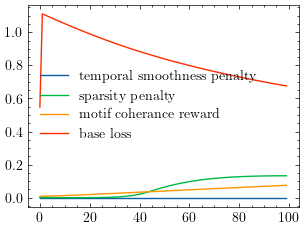

DoS
[3933]
[3927]
torch.Size([10144, 53])
torch.Size([10144])
temporal smoothness penalty 0.0
motif coherance reward: 0.0075803701765835285
sparsity penalty 0.0
base_loss: 0.33693012595176697
total loss: 0.3293497562408447

temporal smoothness penalty 0.0
motif coherance reward: 0.00805460661649704
sparsity penalty 0.0
base_loss: 0.9010190963745117
total loss: 0.8929644823074341

temporal smoothness penalty 0.0
motif coherance reward: 0.00850672833621502
sparsity penalty 0.0
base_loss: 0.8952053785324097
total loss: 0.8866986632347107

temporal smoothness penalty 0.0
motif coherance reward: 0.008973198011517525
sparsity penalty 0.0
base_loss: 0.8892853856086731
total loss: 0.8803122043609619

temporal smoothness penalty 0.0
motif coherance reward: 0.0094588752835989
sparsity penalty 0.0
base_loss: 0.8833481669425964
total loss: 0.8738892674446106

temporal smoothness penalty 0.0
motif coherance reward: 0.00996441300958395
sparsity penalty 0.0
base_loss: 0.8774352669715881
total loss: 0

100%|██████████| 9/9 [00:00<00:00, 14.28it/s]


DoS


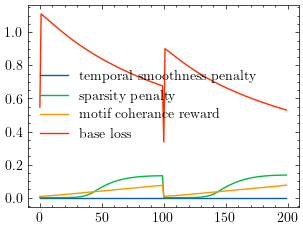

Reconnaissance
[4188]
[4184]
torch.Size([10138, 53])
torch.Size([10138])
temporal smoothness penalty 0.0
motif coherance reward: 0.007557508070021868
sparsity penalty 2.013036464632023e-06
base_loss: 0.41800642013549805
total loss: 0.41045093536376953

temporal smoothness penalty 0.0
motif coherance reward: 0.008024608716368675
sparsity penalty 2.013036464632023e-06
base_loss: 0.9820271134376526
total loss: 0.9740045070648193

temporal smoothness penalty 0.0
motif coherance reward: 0.008472571149468422
sparsity penalty 2.013036464632023e-06
base_loss: 0.9761751294136047
total loss: 0.9677045941352844

temporal smoothness penalty 0.0
motif coherance reward: 0.008936053141951561
sparsity penalty 2.013036464632023e-06
base_loss: 0.9702016711235046
total loss: 0.9612676501274109

temporal smoothness penalty 0.0
motif coherance reward: 0.009419534355401993
sparsity penalty 2.013036464632023e-06
base_loss: 0.9641984105110168
total loss: 0.9547808766365051

temporal smoothness penalty 0.0
mot

100%|██████████| 9/9 [00:00<00:00, 14.30it/s]


Reconnaissance


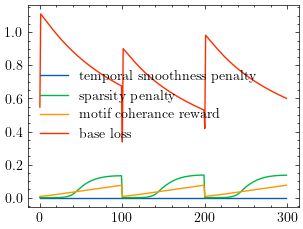

Theft
[4240]
[4233]
torch.Size([9451, 53])
torch.Size([9451])
temporal smoothness penalty 0.0
motif coherance reward: 0.007562041748315096
sparsity penalty 0.0
base_loss: 0.2881225049495697
total loss: 0.2805604636669159

temporal smoothness penalty 0.0
motif coherance reward: 0.008034556172788143
sparsity penalty 0.0
base_loss: 0.8526894450187683
total loss: 0.84465491771698

temporal smoothness penalty 0.0
motif coherance reward: 0.008487781509757042
sparsity penalty 0.0
base_loss: 0.8473032712936401
total loss: 0.8388155102729797

temporal smoothness penalty 0.0
motif coherance reward: 0.008956647478044033
sparsity penalty 0.0
base_loss: 0.8417928218841553
total loss: 0.8328361511230469

temporal smoothness penalty 0.0
motif coherance reward: 0.009445476345717907
sparsity penalty 0.0
base_loss: 0.8362458348274231
total loss: 0.8268003463745117

temporal smoothness penalty 0.0
motif coherance reward: 0.009954744949936867
sparsity penalty 0.0
base_loss: 0.8306933641433716
total loss: 

100%|██████████| 9/9 [00:00<00:00, 15.05it/s]


Theft


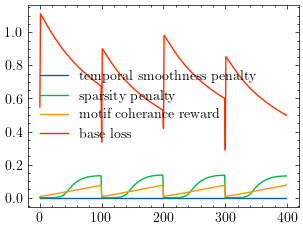

<IPython.core.display.Javascript object>

In [ ]:
import copy

metrics = {}
epoch_metrics = {}

for attack, subG in yield_class_graphs(pyg_lg):
    if attack == 'Benign': 
        continue
    
    print(attack)

    is_star, is_fan = subG.x[:, 51], subG.x[:, 52]
    end_times, start_times = subG.x[:, 50], subG.x[:, 49]
    
    scanning_star_nodes = is_star.nonzero(as_tuple=True)[0]
    fan_nodes = is_fan.nonzero(as_tuple=True)[0]
    
    src, dst = subG.edge_index[0], subG.edge_index[1]
    star_motifs = []
    for hub in scanning_star_nodes.tolist():
        lg_nodes = (src == hub).nonzero(as_tuple=True)[0].tolist()
        if lg_nodes: 
            star_motifs.append(lg_nodes)

    fan_motifs = []
    for sink in fan_nodes.tolist():
        lg_nodes = (dst == sink).nonzero(as_tuple=True)[0].tolist()
        if lg_nodes:
            fan_motifs.append(lg_nodes)
    
    print(max(star_motifs))
    print(max(fan_motifs))
    
    explainer = Explainer(
        model=model,
        algorithm=CustomGNNExplainer(
            epochs=100, 
            node_times = start_times,
            motif_groups = (star_motifs + fan_motifs),
            tv_coef = 1.0,
            motif_coef = 0.01,
            sparsity_coef = 1.0,
            sparsity_threshhold = 0.5,
        ),
        explanation_type='phenomenon',
        node_mask_type='attributes',
        edge_mask_type=None,
        model_config=ModelConfig(
            mode='multiclass_classification',
            task_level='node',
            return_type='raw',
        ),
    )  
    
    print(subG.x.shape)
    print(subG.Attack.shape)

    x = subG.x[:, :49]
    explanation = explainer(
        x=x,
        edge_index=subG.edge_index.to(device),
        target=subG.Attack,
    )
    
    metrics[attack] = explanation 
    subG_cp = copy.deepcopy(subG)
    subG_cp.x = subG_cp.x[:, :49]
    
    # softmask metrics
    fp, fn, c = evaluate_softmask(model, subG_cp, explanation.node_mask)
    metrics[f'{attack} softmask metrics'] = fp, fn, c
    print(f'\tfp: {fp:.3f}')
    print(f'\tfn: {fn:.3f}')
    print(f'\tc: {c:.3f}')
    
    # sparsity curve
    metrics[f'{attack} sparsity curve'] = evaluate_sparsity_threshholds(
        model, subG_cp, explanation.node_mask)
    
    del subG_cp
    
    # regularization curves
    print(attack)
    with plt.style.context('science'): 
        for m, l in explainer.algorithm.epoch_metrics.items():
            y = [ll.detach().numpy() for ll in l]
            plt.plot(y)

        plt.legend(explainer.algorithm.epoch_metrics.keys())
        plt.show()
        
    epoch_metrics[attack] = explainer.algorithm.epoch_metrics
    

fid-


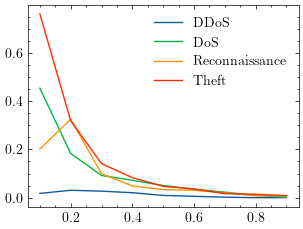

fid+


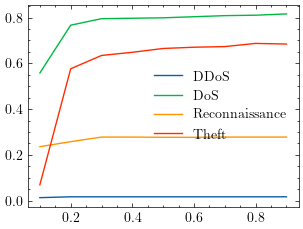

c


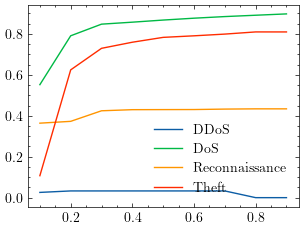

<IPython.core.display.Javascript object>

In [12]:
# plot sparsity curves
with plt.style.context('science'): 
    for metric in ('fid-', 'fid+', 'c'):
        print(metric)
        for attack in le['Attack'].classes_:
            if attack == 'Benign': 
                continue

            m = metrics[f'{attack} sparsity curve']
            plt.plot(m['s'], m[metric])
        
        plt.legend(le['Attack'].classes_[1:])
        plt.show()   

In [13]:
metrics['epoch metrics'] = explainer.algorithm.epoch_metrics
with open('../../interm/nidse_metrics', 'wb') as f:
    pickle.dump(metrics, f)

<IPython.core.display.Javascript object>